# 0.0 Imports


In [4]:
import numpy  as np
import pandas as pd
import scikitplot as skplt
import pickle
import inflection
import seaborn as sns
import math
import gzip

from matplotlib import pyplot as plt

from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh

## 0.1 Loading Dataset


In [5]:
df_raw = pd.read_csv('data/train.csv')

In [6]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 Data Description

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [9]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.2 Data Dimension


In [10]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print ('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.3 Data Types

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Data Descriptive

In [13]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
#vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

#vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0 )

# 3.0 Data Filtering

In [17]:
df3 = df2.copy()

# 4.0 EDA

In [18]:
df4 = df3.copy()

## 4.1 Análise Univariada

In [19]:
df4['response'].value_counts()

response
0    334399
1     46710
Name: count, dtype: int64

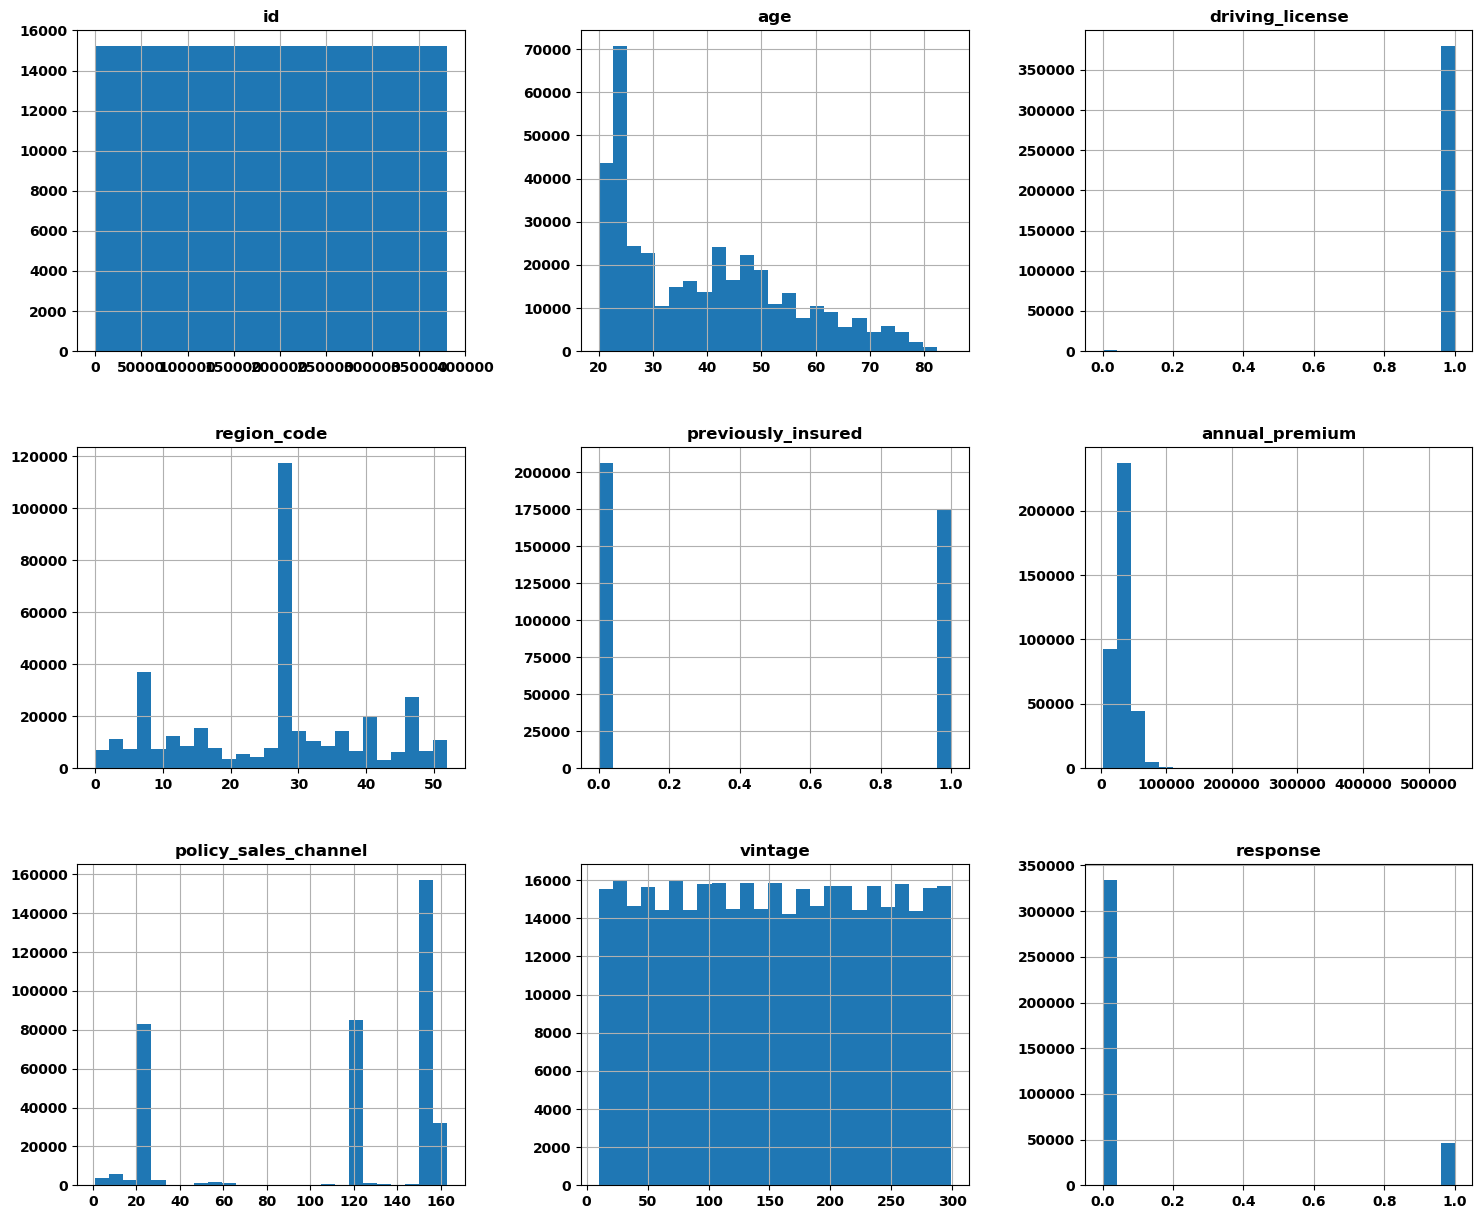

In [20]:
num_attributes.hist(bins=25, figsize=(18, 15));

<Axes: xlabel='response', ylabel='age'>

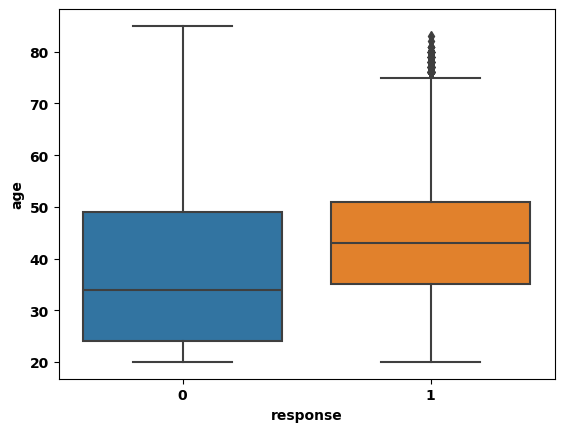

In [21]:
#age
sns.boxplot(x='response', y='age',data=df4)

### 4.1.2. Anual Income

<Axes: xlabel='response', ylabel='annual_premium'>

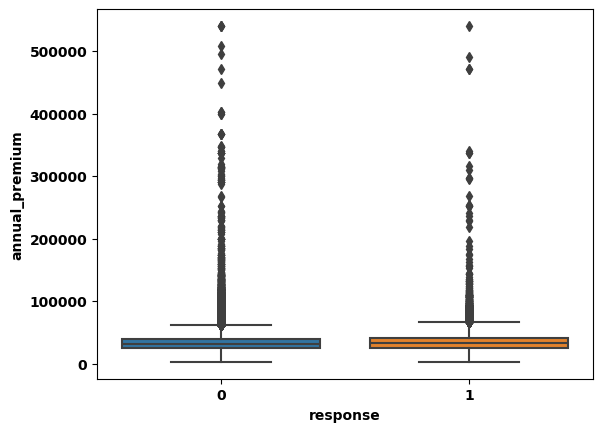

In [22]:
sns.boxplot( x='response', y='annual_premium', data=df4 )

In [23]:
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]

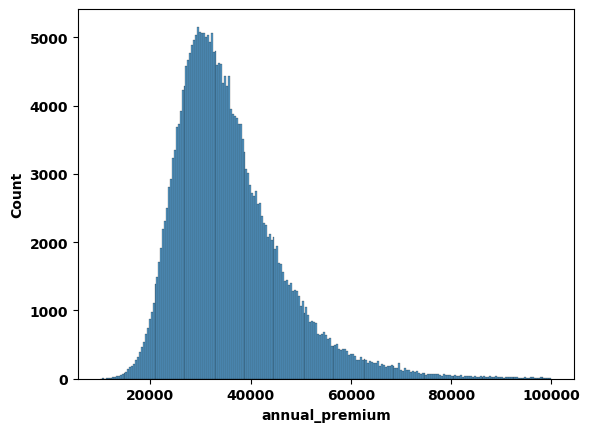

In [24]:
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

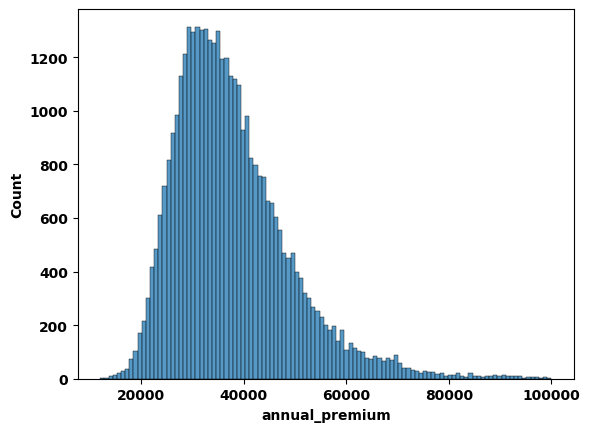

In [25]:
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

### 4.1.3. Driving License

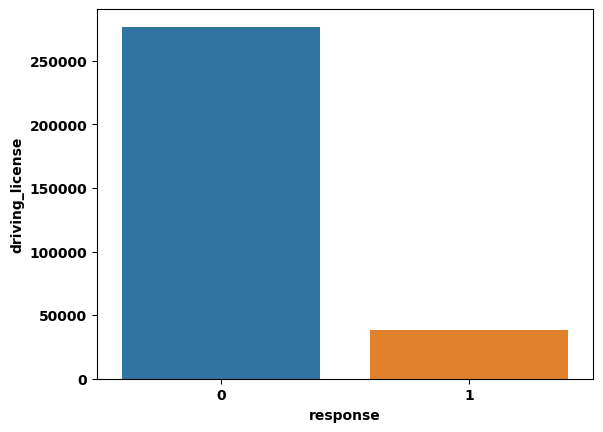

In [26]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

### 4.1.4. Region Code

<Axes: xlabel='region_code', ylabel='id'>

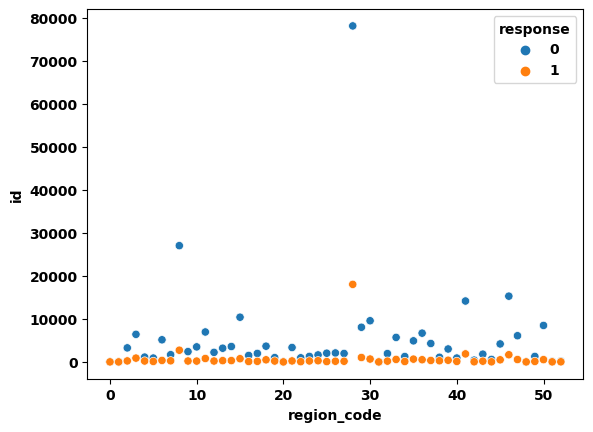

In [27]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

### 4.1.5. Previously Insured

<Axes: xlabel='previously_insured', ylabel='id'>

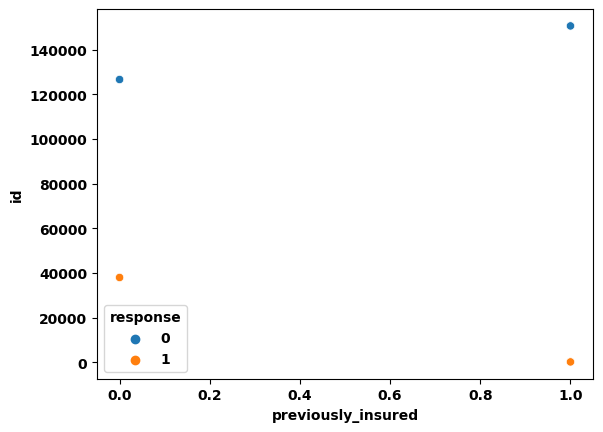

In [28]:
aux0 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='previously_insured', y='id', hue='response', data=aux0 )

In [29]:
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


### 4.1.6. Vehicle Age

In [30]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,137861
1,below_1_year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


### 4.1.7. Vehicle Damage

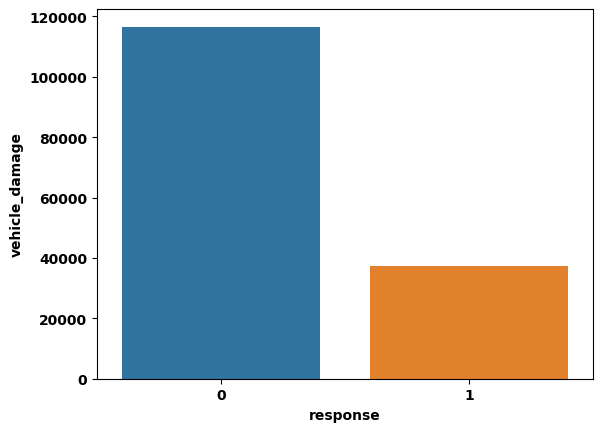

In [31]:
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.8. Policy Sales Channel - Stacked Percentage Bar

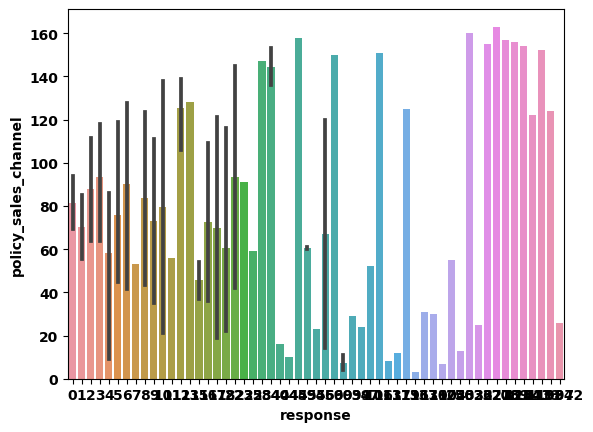

In [32]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

### 4.1.9. Vintage

<Axes: xlabel='vintage', ylabel='Count'>

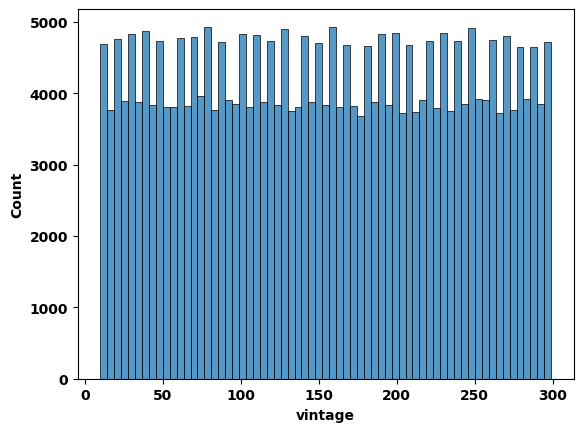

In [33]:
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

# 5.0. Data Preparation

In [34]:
df5 = df4.copy()

In [35]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [37]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( 'src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [38]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( 'src/features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( 'src/features/vintage_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In [40]:
# gender - One Hot Encoding / Target Encoding
df5 = pd.get_dummies( df5, prefix='gender', columns=['gender'],dtype=int)

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( 'src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'],dtype=int)

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( 'src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4. Validation Preparation

In [41]:
x_validation = x_test.copy()
y_validation = y_test.copy()

In [42]:
# gender
x_validation = pd.get_dummies( x_validation, prefix='gender', columns=['gender'] )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. Feature Selection

## 6.1. Feature Importance

In [ ]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                annual_premium    0.273114
0                       vintage    0.246355
0                           age    0.161242
0                   region_code    0.104355
0                vehicle_damage    0.070478
0          policy_sales_channel    0.058227
0            previously_insured    0.058131
0      vehicle_age_below_1_year    0.014724
0  vehicle_age_between_1_2_year    0.007169
0      vehicle_age_over_2_years    0.003629
0                 gender_Female    0.001039
0                   gender_Male    0.000971
0               driving_license    0.000567


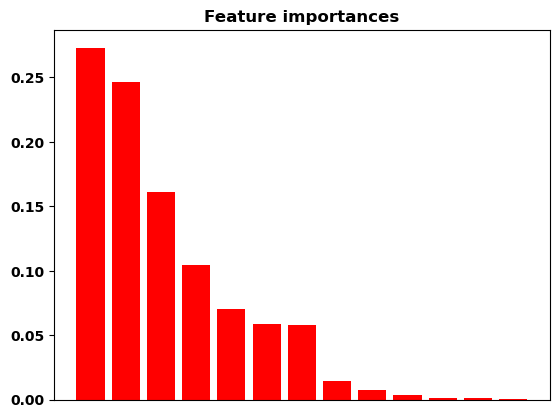

In [ ]:
importances = forest.feature_importances_


# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, importances):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 ).sort_values( 'importance', ascending=False )
    
print( df )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(x= df['feature'], height=df['importance'],data=df,color="r")
plt.xticks([])
plt.show()

# 7.0. Machine Learning

In [43]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]

## 7.1. KNN Classifier

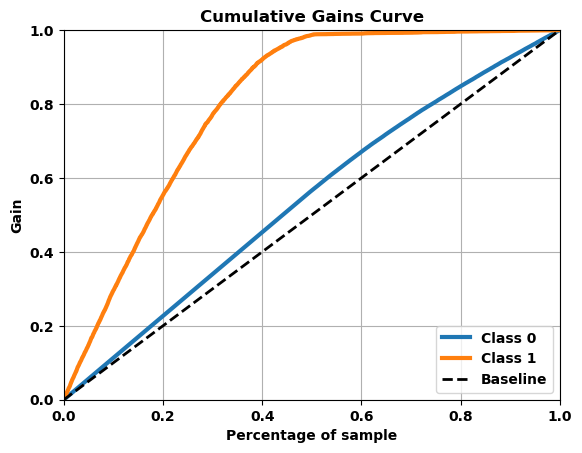

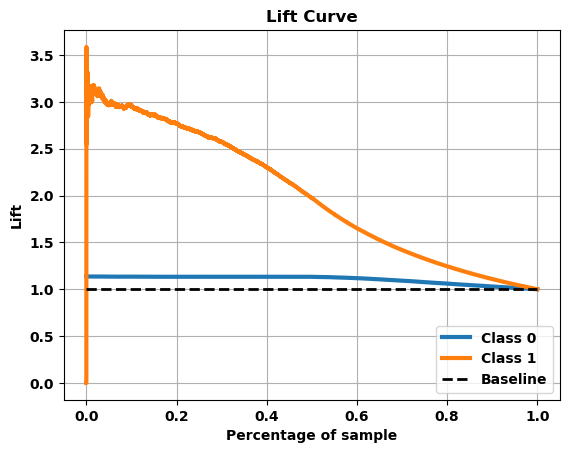

In [153]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=30)

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_knn );

## 7.2. Logistic Regression

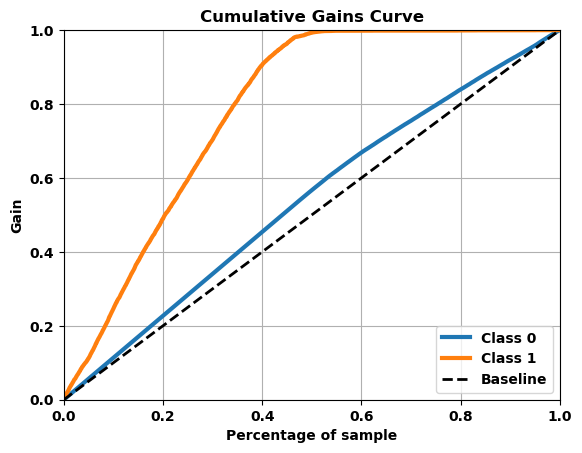

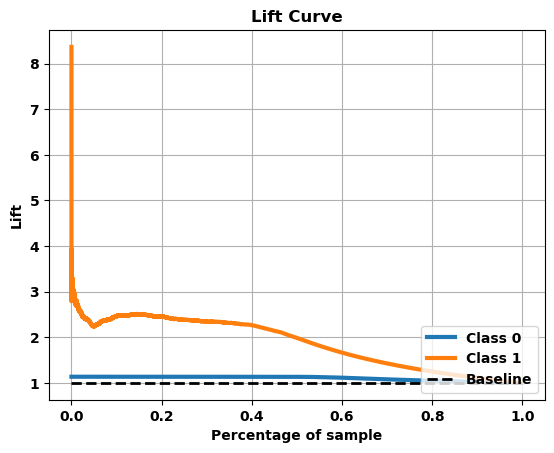

In [77]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_lr );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_lr );

## 7.3. Extra Trees Classifier



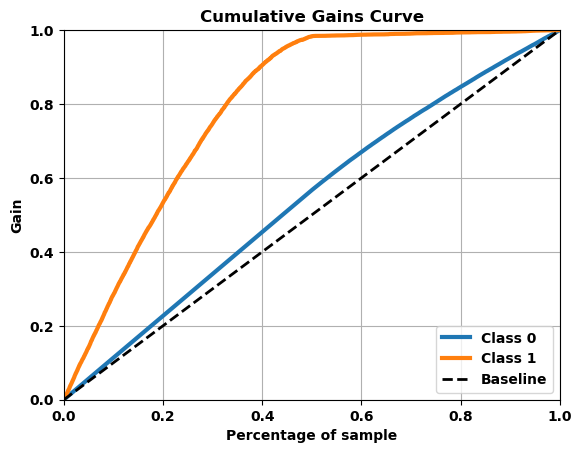

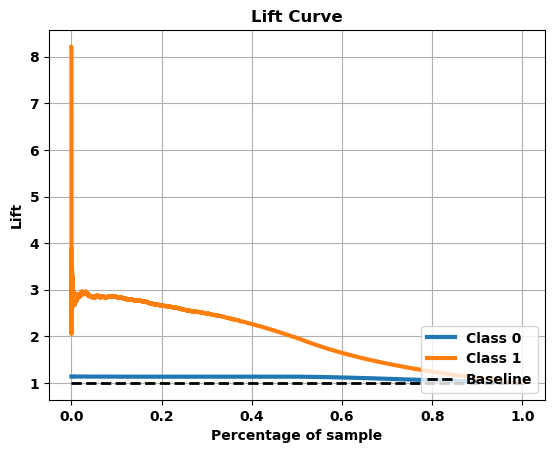

In [ ]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=100, n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_et );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_et );

## 7.4. Random Forest

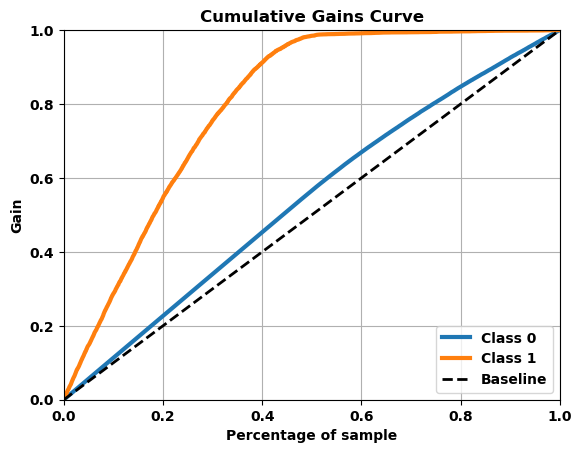

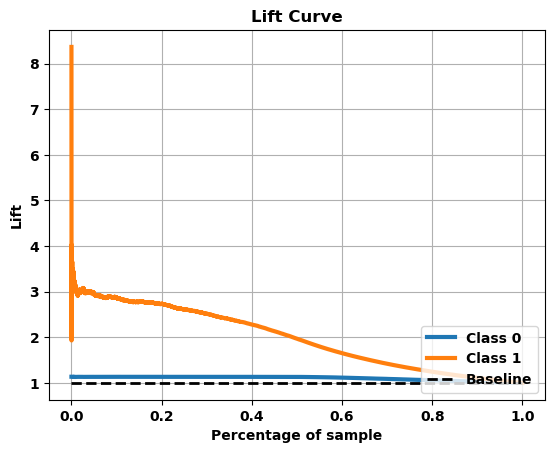

In [116]:
# model definition
rf = en.RandomForestClassifier( n_estimators=80, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_rf );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_validation, yhat_rf );

# 7.5 Model Performance Metrics

In [45]:
def precision_at_k( data, k=math.floor(0.2*x_val.shape[0]) ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'])

def recall_at_k( data, k=math.floor(0.2*x_val.shape[0]) ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'])

### 7.5.1 KNN Performance

In [154]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20 = precision_at_k(df8)
print('precision_at_2000: {}'.format(precision_at_20))

# compute recall at k
recall_at_20 = recall_at_k(df8)
print('recall_at_2000: {}'.format(recall_at_20))

precision_at_2000: 0.3307710595134321
recall_at_2000: 0.5535074923750166


### 7.5.2 Logistic Regression Performance

In [ ]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20 = precision_at_k(df8)
print('precision_at_2000: {}'.format(precision_at_20))

# compute recall at k
recall_at_20 = recall_at_k(df8)
print('recall_at_2000: {}'.format(recall_at_20))

precision_at_2000: 0.29772565179491245
recall_at_2000: 0.4890016920473773


### 7.5.3 Extra Tree Performance

In [ ]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20 = precision_at_k(df8)
print('precision_at_2000: {}'.format(precision_at_20))

# compute recall at k
recall_at_20 = recall_at_k(df8)
print('recall_at_2000: {}'.format(recall_at_20))

precision_at_2000: 0.3247483952769633
recall_at_2000: 0.5333853963295587


### 7.5.4 Random Forest Performance

In [117]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20 = precision_at_k(df8)
print('precision_at_2000: {}'.format(precision_at_20))

# compute recall at k
recall_at_20 = recall_at_k(df8)
print('recall_at_2000: {}'.format(recall_at_20))

precision_at_2000: 0.3264917980822569
recall_at_2000: 0.5463466383768731


# 8.0 HYPERPARAMETER FINE TUNING

In [183]:
k_values = list([1,3,5,10,15,20,25,30])

df50 = pd.DataFrame(columns=['k_neighbors', 'recall_at_2000'])

for n_neighbors in k_values:
    knn_model = nh.KNeighborsClassifier( n_neighbors=n_neighbors )

    # model training
    knn_model.fit( x_train, y_train )

    # model prediction
    yhat_knn = knn_model.predict_proba( x_val )
    
    # copy dataframe
    df8 = x_val.copy()
    df8['response'] = y_validation.copy()

    # propensity score
    df8['score'] = yhat_knn[:, 1].tolist()

    # sort clients by propensity score
    df8 = df8.sort_values( 'score', ascending=False )

    # compute recall at k
    recall_at_20 = recall_at_k(df8)
    print('Para k_neighbors: {}, recall_at_2000: {}'.format(n_neighbors,recall_at_20))
    
    df50.loc[len(df50)] = [n_neighbors, recall_at_20]
    
df51 = df50.sort_values('recall_at_2000', ascending=False).head(1)
print('k : {}'.format(df51.iloc[0,0]))

Para k_neighbors: 1, recall_at_2000: 0.3565840074260708
Para k_neighbors: 3, recall_at_2000: 0.47990982628298634
Para k_neighbors: 5, recall_at_2000: 0.5028510807585201
Para k_neighbors: 10, recall_at_2000: 0.5175706139769262
Para k_neighbors: 15, recall_at_2000: 0.5305662378994829
Para k_neighbors: 20, recall_at_2000: 0.5430314281925475
Para k_neighbors: 25, recall_at_2000: 0.5479379392653494
Para k_neighbors: 30, recall_at_2000: 0.5535074923750166
k : 30.0


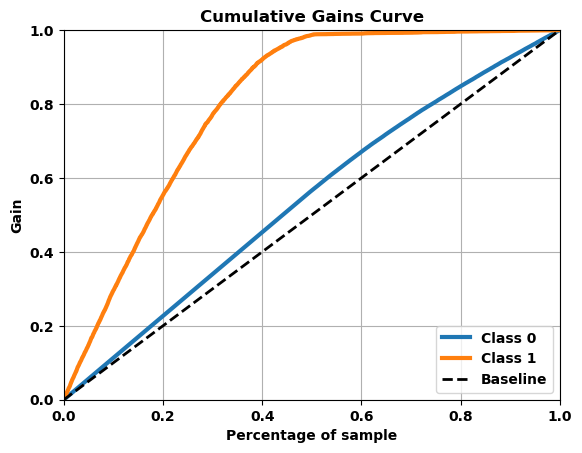

In [184]:
# model definition
knn_model_tuned = nh.KNeighborsClassifier( n_neighbors=30)

# model training
knn_model_tuned.fit( x_train, y_train )

# model prediction
yhat_knn_tuned = knn_model_tuned.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation, yhat_knn_tuned );


# 9.0. Deploy to Production

In [185]:
# Save trained model
pickle.dump( knn_model_tuned,open( 'C:/Users/rseme/Desktop/propensao-de-compra/src/model/knn_model.pkl', 'wb' ) )

## 9.1. Health Insurance Class

In [173]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path = 'C:/Users/rseme/Desktop/propensao-de-compra/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

        snakecase = lambda x: inflection.underscore (x)

        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.fit_transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.fit_transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.fit_transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5 = pd.get_dummies( df5, prefix='gender', columns=['gender'] )

        # region_code - Target Encoding / Frequency Encoding
        target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
        df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
#from healthinsurance import HealthInsurance

# loading model
model = pickle.load( open( 'C:/Users/rseme/Desktop/propensao-de-compra/src/model/model_random_forest.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/rseme/Desktop/propensao-de-compra/src/model/model_random_forest.pkl'

## 9.3. API Tester

In [186]:
import requests
import json

In [187]:
# loading test dataset
df_test = x_test
df_test['response'] = y_test

#df_test = pd.read_csv('data/test.csv')
#df_test['response'] = y_test

In [188]:
df_test.shape


(63090, 12)

In [189]:
df_test['response'].sum()

7541

In [178]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [190]:
# API Call
url = 'http://127.0.0.1:5000/predict'
#url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [202]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'prediction', ascending=False ).head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction
57040,105219,Male,0.230769,1,3.0,0,below_1_year,0,-1.164044,124.0,0.633218,0,0.35
37686,114582,Male,0.230769,1,35.0,0,below_1_year,0,-1.144147,124.0,0.588235,0,0.30
27318,6739,Male,0.261538,1,15.0,0,below_1_year,0,-1.190727,26.0,0.591696,1,0.30
32511,68623,Male,0.200000,1,37.0,0,below_1_year,0,-1.070517,156.0,0.892734,0,0.30
11623,103663,Female,0.261538,1,28.0,0,below_1_year,0,-1.123424,122.0,0.844291,1,0.30
8952,111781,Female,0.276923,1,45.0,0,below_1_year,0,-1.043009,122.0,0.809689,1,0.30
43727,185983,Male,0.230769,1,28.0,0,below_1_year,0,-1.182658,26.0,0.567474,0,0.25
4241,272747,Female,0.261538,1,41.0,0,below_1_year,0,-1.185500,26.0,0.636678,0,0.25
54612,115272,Female,0.107692,1,30.0,0,below_1_year,0,-0.969288,124.0,0.629758,0,0.25
5725,295944,Male,0.230769,1,30.0,0,below_1_year,0,-1.121315,124.0,0.525952,0,0.25
